In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
plt.rcParams.update({'font.size': 16})
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

### Env

In [3]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
t_min=0
t_max=10

t0 = 0
t_step = 1
n_steps = 8
n_prev = 3

delta = beta / (2 * m)
omega_0 = k / m

impact_amplitude = 1
damping_ratio = 0.05

In [4]:
def x_impact(t, a=impact_amplitude, b=damping_ratio):
#     if t < 0:
#         return 1
    return a * np.exp(-t * b)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     impact=x_impact, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * impact(t0)
        )
        t0 += step
    return res

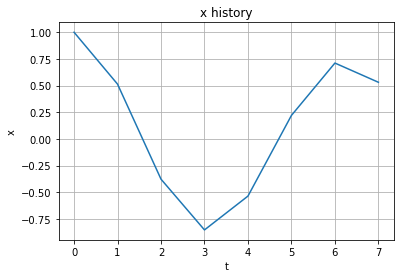

In [5]:

history = generate_history(t0, t_step, n_steps)

plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [6]:
class SimpleModel(gym.Env):
    
    def __init__(self, history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k,
                 n_prev=n_prev):
        self._history = history
        self._big_f_0 = big_f_0
        self._k = k

        self._last_x = self._history[:n_prev]
        self._t0 = t0
        self.t = t0
        self._t_step = t_step
        self._n_steps = n_steps
        self._n_prev = n_prev
        self._i = self._n_prev - 1
        self.t = self._t0 + self._t_step * self._i
        
        self.observation_space = spaces.Box(low=-100, high=100, shape=(self._n_prev,), dtype=np.float32)
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)
#         self.action_space = spaces.Box(low=-100, high=100, shape=(3,), dtype=np.float32)
 
        
    def _x_model(self, m, delta, big_omega, t=None):
        """Returns the model position."""
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        if t is None:
            t = self.t
        return big_b * np.cos(big_omega * t - theta)
    
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        f_0 = self._big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res
    
    def step(self, action):

        # step
        self._i += 1
        self.t += self._t_step

        # reward
        m_, delta_, big_omega_ = action[0], action[1], action[2]
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        x_ = self._x_model(m_, delta_, big_omega_)
#         reward = - (x_ - self._history[self._i]) ** 2
        reward = - ((x_ - self._history[self._i]) / self._history[self._i]) ** 2 # TODO!!!!!-------------

        # done
        done = self._i >= self._n_steps - 1
        
        # info
        info = {}
        
        # obs
        if self._n_prev > 1:
            self._last_x = self._last_x[1:] + [x_]
        else:
            self._last_x = x_
        obs = np.array(self._last_x).reshape((-1,1))
        
        return obs, reward, done, info
    
    def reset(self):
        self._i = self._n_prev - 1
        self.t = self._t0 + self._t_step * self._i
        self._last_x = self._history[:self._n_prev]
        return np.array(self._last_x).reshape((-1,1))
    
    def render(self):
        pass

    

In [7]:
class ImpactWrapper(gym.ObservationWrapper):
    
    def __init__(self, env, impact_func, param1, param2):
        super().__init__(env)
        self.impact_func = impact_func
        self.param1 = param1
        self.param2 = param2
        self.observation_space = spaces.Box(low=-100, high=100, shape=(2 * self.env._n_prev + 2,), dtype=np.float32)
        
    def _get_impact(self, obs):
        o = list(obs.reshape((-1,)))
        impact = [self.impact_func(self.t - t_step * i) for i in range(n_prev)]
        o = np.array([self.param1, self.param2] + impact + o)
        return o
    
    def step(self, action):
        o, r, d, info =  self.env.step(action)
        return self._get_impact(o), r, d, info
        
    def reset(self):
        o = self.env.reset()
        return self._get_impact(o)

In [8]:
class NormActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._low = self.env.action_space.low
        self._high = self.env.action_space.high
        
    def step(self, action):
        action = (action * (self._high - self._low) + self._high + self._low) / 2
        o, r, d, info =  self.env.step(action)
        return o, r, d, info

# Some tests

In [9]:
history = generate_history(t0, t_step, n_steps, impact=lambda t: 1)
env = SimpleModel(history, t0, t_step, n_steps)

In [10]:
for i in range(20):
    env.reset()
    o, r, d, _ = env.step([m, delta, big_omega])
    assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([m, delta, big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

reset_1 = env.reset()
for i in range(n_steps-n_prev):
    o, r, d, _ = env.step([0.1, 0.1, 0.1])
reset_2 = env.reset()
assert np.all(reset_1 == reset_2)

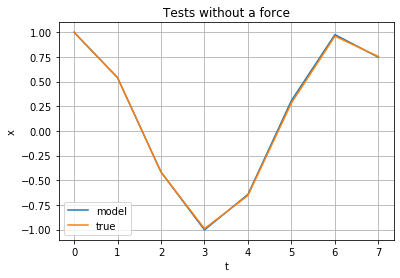

In [11]:
points = list(env.reset().reshape((-1,)))
points += [env.step([m, delta, big_omega])[0][-1][0] for _ in range(len(history) - n_prev)]
points = np.array(points).reshape((-1,))

# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [12]:
history = generate_history(t0, t_step, n_steps, impact=x_impact)
env = SimpleModel(history, t0, t_step, n_steps)
env = ImpactWrapper(env, x_impact, param1=impact_amplitude, param2=damping_ratio)

In [13]:
# points = [env.reset()]
# points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
# points = np.array(points).T

# assert points[0].shape == points[1].shape
# plt.plot(points[0]*points[1] + 0.01, label="model with force")
# plt.plot(points[0], label="model")
# plt.plot(points[1], label="force")
# plt.plot(history, label="true")
# plt.grid(True)
# plt.legend()
# plt.title("Tests with a force")
# plt.xlabel("t")
# plt.ylabel("x")
# plt.show()

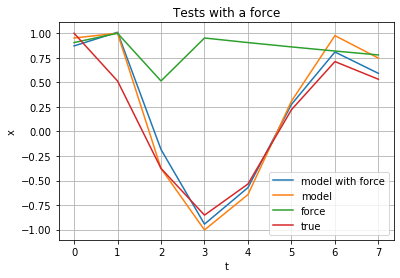

In [14]:
points = list(env.reset().reshape((-1,))[2:].reshape((-1,2)))
points += [env.step([m, delta, big_omega])[0][n_prev+1::n_prev] for _ in range(len(history) - n_prev)]
points = np.array(points).T

assert points[0].shape == points[1].shape
plt.plot(points[0]*points[1] + 0.01, label="model with force")
plt.plot(points[1], label="model")
plt.plot(points[0], label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# CE

from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb

In [15]:
test_history = generate_history(t0, t_step, n_steps)
test_env = SimpleModel(test_history, t0, t_step, n_steps)
test_env = ImpactWrapper(test_env, x_impact, impact_amplitude, damping_ratio)
# test_env = NormActionWrapper(test_env)

In [16]:
import gym
import math
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, base_env, h_size=16):
        super(Agent, self).__init__()
        # state, hidden layer, action sizes
        self.s_size = base_env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = base_env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.batch_norm()
        x = F.dropout(x, p=0.2)
        x = torch.tanh(self.fc2(x) / 5000)
#         print("x:", x)
        return x.cpu().data
        
    def evaluate(self, env, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = env.step(action.numpy())
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(test_env, h_size=32).to(device)

observation space: Box(8,)
action space: Box(3,)
  - low: [ 0.  -2.  -0.1]
  - high: [10.   2.   0.1]


In [18]:
# def plot_result(env, agent, title_info=""):
#     s = env.reset()
#     d = False
#     points = [s[0]]
#     while not d:
#         state = torch.from_numpy(s).float().to(device)
#         a = list(agent(state).numpy())
#         print(a)
#         s, r, d, _ = env.step(a)
#         points.append(s[0])

#     plt.plot(points, label="model")
#     plt.plot(history, label="true")
#     plt.title("CE training" + title_info)
#     plt.xlabel("t")
#     plt.ylabel("x")
#     plt.grid(True)
#     plt.legend()
#     plt.show()

In [19]:
def plot_result(env, model, title_info=""):
    s = env.reset()
    d = False
    points = list(s)[-n_prev:]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(model(state).numpy())
        s, r, d, _ = env.step(a)
        points.append(s[-1])

    plt.plot(points, label="model")
    plt.plot(history, label="true")
    plt.title("CE training" + title_info)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

Episode 0


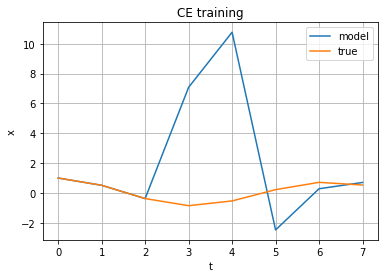

Episode 200	Average Score: -50.29	Best Average Score: -50.29
55.25716491770608 9.04814789840327 71.41402239257522


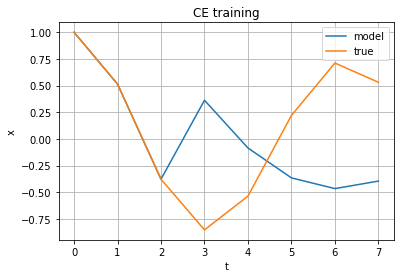

Episode 400	Average Score: -30.06	Best Average Score: -30.06
61.067085494851305 8.186898039137935 72.85660848981772


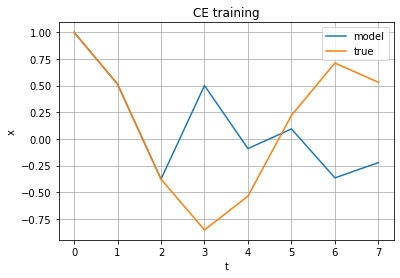

Episode 600	Average Score: -405.29	Best Average Score: -30.06
67.48788028465309 7.407626428726764 74.32833528769902


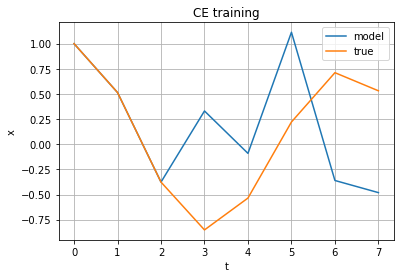

Episode 800	Average Score: -767.05	Best Average Score: -30.06
74.58377861670964 6.702529950324054 75.82979143769391


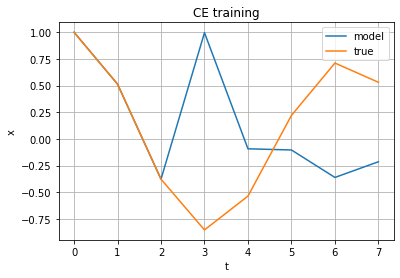

Episode 1000	Average Score: -1046.67	Best Average Score: -30.06
82.42576310418404 6.064548228400948 77.3615774822255


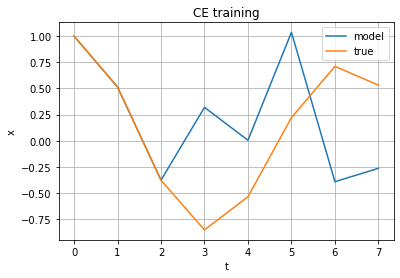

Episode 1200	Average Score: -2761.14	Best Average Score: -30.06
91.09227970631348 5.487292930757126 78.92430609486564


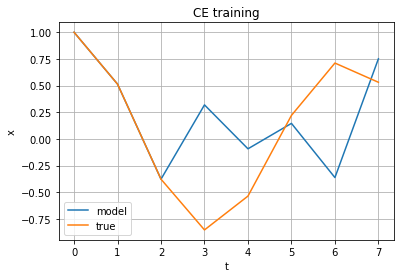

Episode 1400	Average Score: -762.60	Best Average Score: -30.06
100.67002244923151 4.964983799935317 80.51860232538854


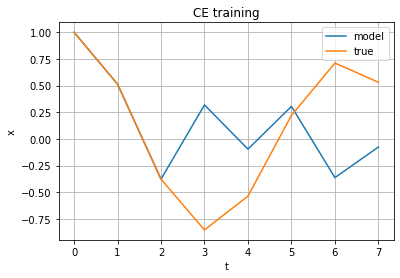

Episode 1600	Average Score: -353.33	Best Average Score: -30.06
111.25480065492714 4.492390773499101 82.14510384977368


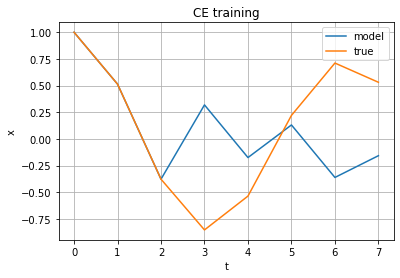

Episode 1800	Average Score: -48.19	Best Average Score: -30.06
122.95249735351658 4.064781613604211 83.80446122525935


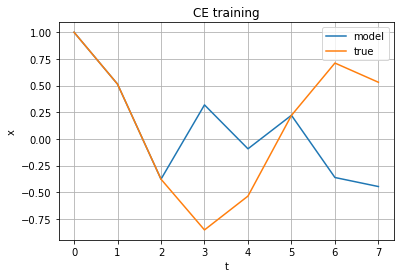

Episode 2000	Average Score: -374.46	Best Average Score: -30.06
135.88012846614183 3.677874521460117 85.49733815054817


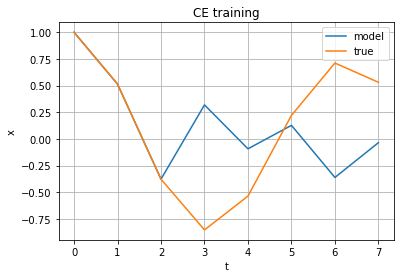

Episode 2200	Average Score: -2424.37	Best Average Score: -30.06
150.16701335385392 3.3277952621940243 87.22441173126889


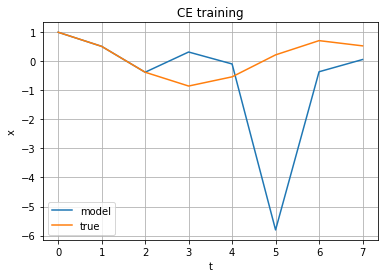

Episode 2400	Average Score: -26415.76	Best Average Score: -30.06
165.95606844186554 3.0110383707937194 88.9863727508005


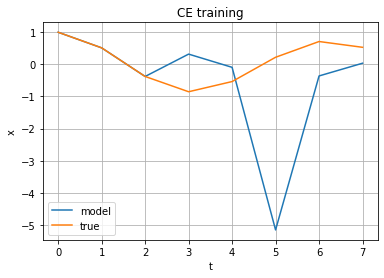

Episode 2600	Average Score: -2440.33	Best Average Score: -30.06
183.40523685972585 2.724432050670879 90.78392594656738


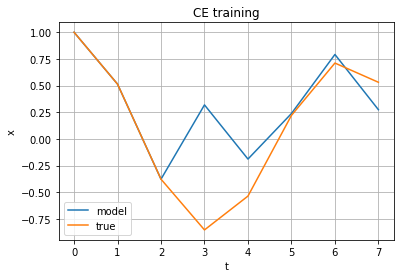

Episode 2800	Average Score: -927.98	Best Average Score: -30.06
202.68906839857615 2.465106413362019 92.61779029191507


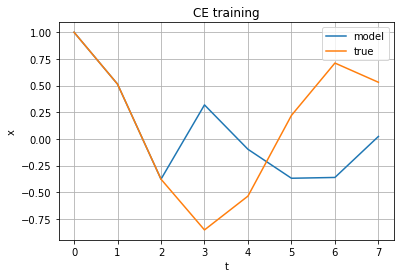

Episode 3000	Average Score: -1728.76	Best Average Score: -30.06
224.0004655903266 2.230464741340194 94.48869928368086


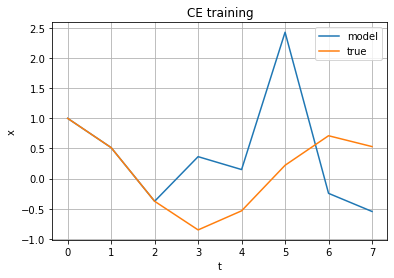

Episode 3200	Average Score: -1542.09	Best Average Score: -30.06
247.5526133753526 2.0181574861819866 96.39740123557274


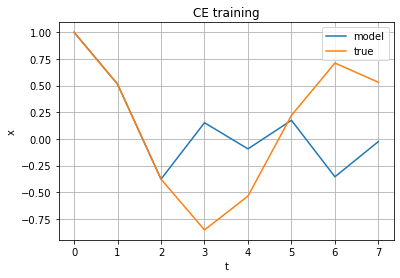

Episode 3400	Average Score: -1490.33	Best Average Score: -30.06
273.5811116618196 1.8260587417244354 98.344659577475


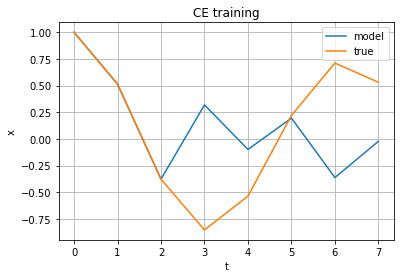

Episode 3600	Average Score: -1369.18	Best Average Score: -30.06
302.34633210933066 1.6522449566294843 100


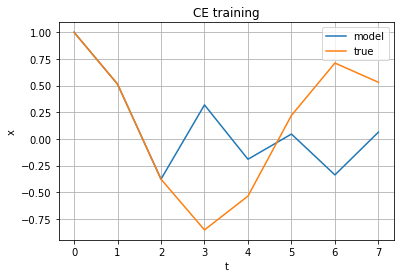

Episode 3800	Average Score: -158.02	Best Average Score: -30.06
334.13602271257656 1.4949756731974462 100


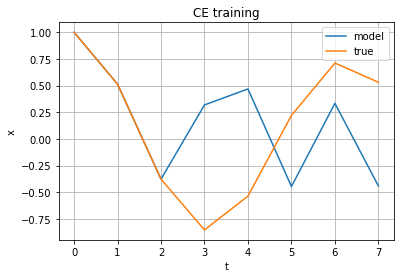

Episode 4000	Average Score: -71.95	Best Average Score: -30.06
369.2681862395043 1.3526760995605478 100


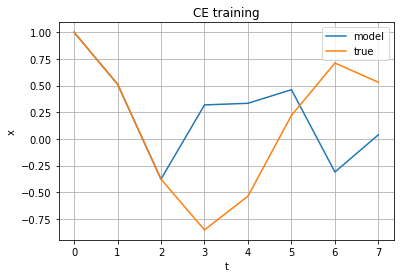

Episode 4200	Average Score: -252.67	Best Average Score: -30.06
408.09426131797017 1.2239213407459084 100


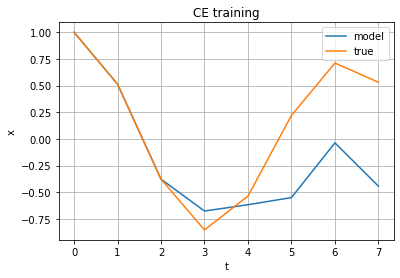

Episode 4400	Average Score: -247.09	Best Average Score: -30.06
451.00263799233073 1.1074221307081 100


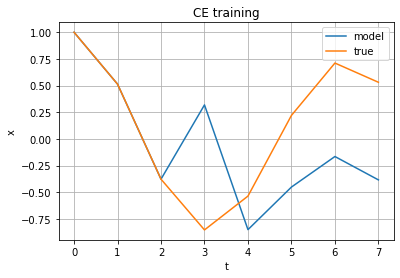

Episode 4600	Average Score: -78.82	Best Average Score: -30.06
498.4225429172544 1.0020119224611754 100


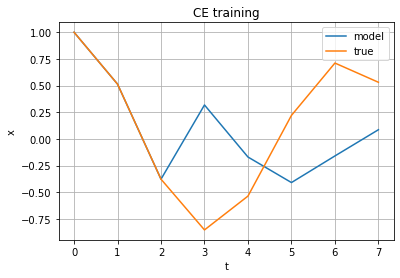

Episode 4800	Average Score: -62.03	Best Average Score: -30.06
550.8283330536232 0.9066352070392095 100


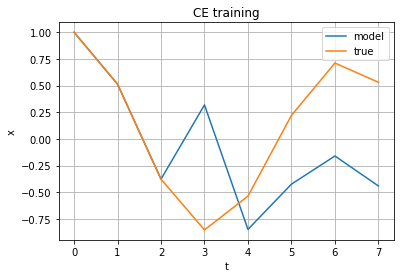

Episode 5000	Average Score: -25.70	Best Average Score: -25.70
608.744240817783 0.8203369443190233 100


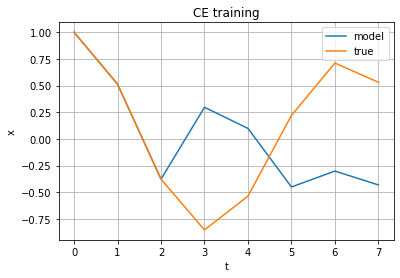

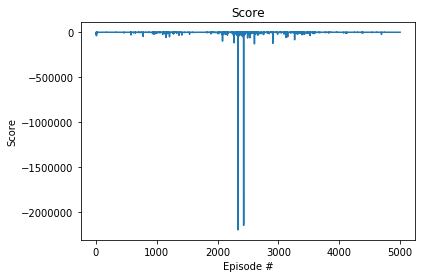

In [20]:
# TODO: improve CEM with CEM hacks

def cem(n_iterations=5000, max_t=1000, gamma=0.8, print_every=200, pop_size=50, percentile=70, sigma=10, new=True,
        c_pop_size=1.0005, c_sigma=0.9995, c_percentile=1.0001, test_env=test_env, lr=0.5, n_eval=10):
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    best_weight = sigma*np.random.randn(agent.get_weights_dim())
    agent.set_weights(best_weight)
    
    print('Episode 0')
    plot_result(test_env, agent)

    best_mean_score = -float("inf")
    for i_iteration in range(1, n_iterations+1):
        
        rnd_impact_amplitude = np.random.uniform(0.5, 1.5)
        rnd_damping_ratio = np.random.uniform(0.03, 0.1)
        
        impact = lambda t: x_impact(t, rnd_impact_amplitude, rnd_damping_ratio)
        history = generate_history(t0, t_step, n_steps, impact=impact)
        env = SimpleModel(history, t0, t_step, n_steps)
        env = ImpactWrapper(env, impact, rnd_impact_amplitude, rnd_damping_ratio)
#         env = NormActionWrapper(env)
    
        
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(int(pop_size))]
        rewards = np.array([agent.evaluate(env, weights, gamma, max_t) for weights in weights_pop])
        
        thr = np.percentile(rewards, percentile)
        elite_weights = [weights_pop[i] for i, r in enumerate(rewards) if r >= thr-0.01]
        
        best_weight = (1 - lr) * best_weight + lr * np.array(elite_weights).mean(axis=0)
        
        rewards = []
        for _ in range(n_eval):
            impact = lambda t: x_impact(t, rnd_impact_amplitude, rnd_damping_ratio)
            history = generate_history(t0, t_step, n_steps, impact=impact)
            env = SimpleModel(history, t0, t_step, n_steps)
            env = ImpactWrapper(env, impact, rnd_impact_amplitude, rnd_damping_ratio)
            r = agent.evaluate(env, best_weight, gamma=1.0) 
            rewards.append(r)
        reward = np.mean(rewards)
        
        scores_deque.append(reward)
        scores.append(reward)
        
        
        pop_size *= c_pop_size
        
        sigma *= c_sigma
        sigma = max(0.0001, sigma)
        
        percentile *= c_percentile
        percentile = min(100, percentile)
        
        if i_iteration % print_every == 0:
            mean_score = np.mean(scores_deque)
            if mean_score > best_mean_score:
                torch.save(agent.state_dict(), 'checkpoint_8_mspe.pth')
                best_mean_score = mean_score
            print('Episode {}\tAverage Score: {:.2f}\tBest Average Score: {:.2f}'.format(i_iteration, mean_score, best_mean_score))
            print(pop_size, sigma, percentile)
            plot_result(test_env, agent)
                      
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)), scores[1:])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score')
plt.show()

In [30]:
import pickle
with open('scores_8_rl_sim_mspe.pkl', 'wb') as f:
    pickle.dump(scores, f)

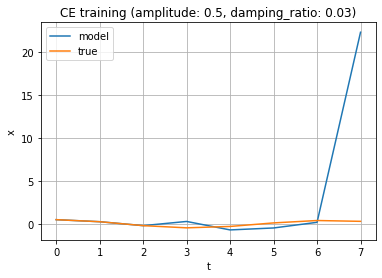

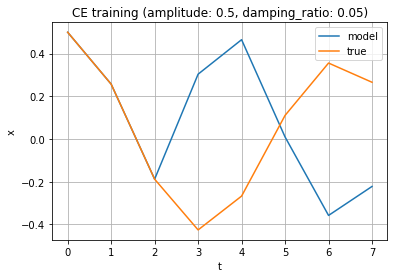

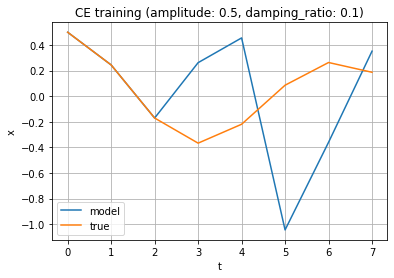

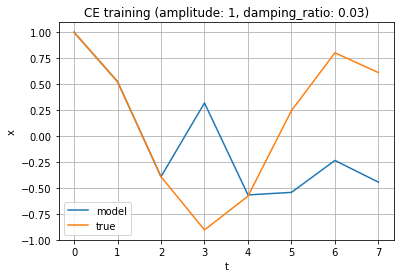

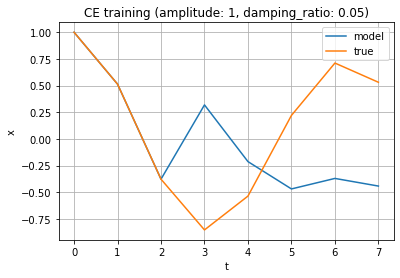

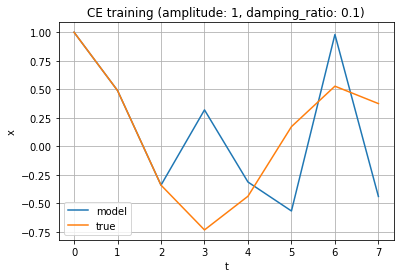

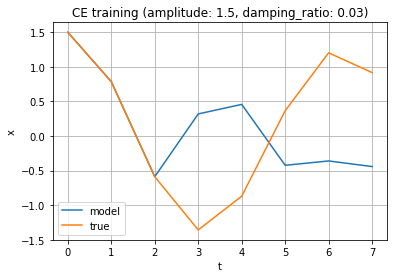

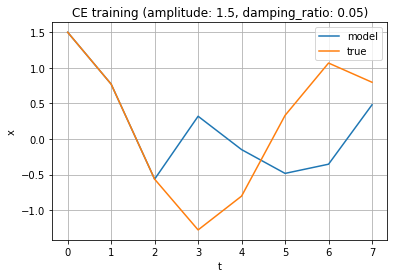

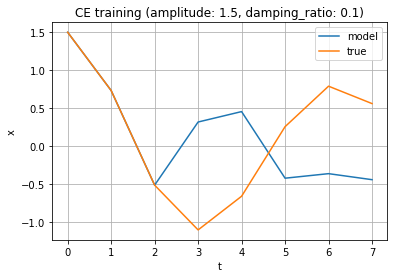

In [21]:
agent.load_state_dict(torch.load('checkpoint_8_mspe.pth'))

impact_amplitude_list = [0.5, 1, 1.5]
damping_ratio_list = [0.03, 0.05, 0.1]

for a in impact_amplitude_list:
    for d in damping_ratio_list:
        impact = lambda t: x_impact(t, a, d)
        history = generate_history(t0, t_step, n_steps, impact=impact)
        env = SimpleModel(history, t0, t_step, n_steps)
        env = ImpactWrapper(env, x_impact, a, d)
#         env = NormActionWrapper(env)
        info = f" (amplitude: {a}, damping_ratio: {d})"
        plot_result(env, agent, info)

# Analysis

https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-2-regression-metrics-d4a1a9ba3d74

In [22]:
def mspe_max(history, predictions, n_prev):
    d = max(history)
    history = np.array(history[n_prev:])
    predictions = np.array(predictions[n_prev:])
    mspe = np.linalg.norm((history - predictions) / d)
    mspe /= len(history)
    return mspe

def mspe(history, predictions, n_prev):
    history = np.array(history[n_prev:])
    predictions = np.array(predictions[n_prev:])
    mspe = np.linalg.norm((history - predictions) / history)
    mspe /= len(history)
    return mspe

In [23]:
def mse(history, predictions, n_prev):
    mse = np.linalg.norm(
        np.array(history[n_prev:]) - np.array(predictions[n_prev:]))
    mse /= len(history[n_prev:])
    return mse

In [24]:
def hist_pred(impact_amplitude, damping_ratio):
    impact = lambda t: x_impact(t, impact_amplitude, damping_ratio)
    history = generate_history(t0, t_step, n_steps, impact=impact)
    env = SimpleModel(history, t0, t_step, n_steps)
    env = ImpactWrapper(env, x_impact, impact_amplitude, damping_ratio)
#     env = NormActionWrapper(env)
    s = env.reset()
    d = False
    predictions = list(s)[-n_prev:]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(agent(state).numpy())
        s, r, d, _ = env.step(a)
        predictions.append(s[-1])
    return history, predictions

In [25]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

# def err(a, d):
#     hist, pred = hist_pred(a, d)
#     return mspe_max(hist, pred, n_prev)

# n = 10
# x = np.linspace(0.5, 1.5, n)
# y = np.linspace(0.03, 0.05, n)
# Z = np.empty((n, n))
# for i in range(n):
#     for j in range(n):
#         Z[i, j] = err(x[i], y[j])


# # im = imshow(Z,cmap=cm.RdBu, )
# fig, ax = plt.subplots(figsize=(6,6))
# ax.imshow(Z,cmap=cm.RdBu, extent=[min(x),max(x),min(y),max(y)],
#           interpolation='nearest', aspect='auto')
# # ax.set_aspect(2)
# colorbar(imshow(Z,cmap=cm.RdBu, )) 
# title(f'mspe max, {n_steps} steps')
# pylab.xlabel(f"impact amplitude")
# pylab.ylabel(f"damping ratio")
# show()

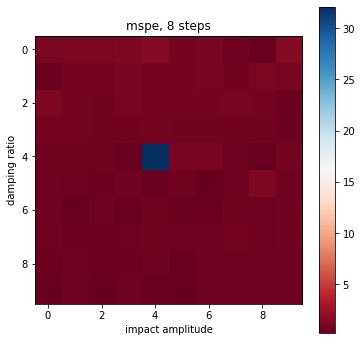

In [26]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def err(a, d):
    hist, pred = hist_pred(a, d)
    return mspe(hist, pred, n_prev)

n = 10
x = np.linspace(0.5, 1.5, n)
y = np.linspace(0.03, 0.05, n)
Z = np.empty((n, n))
for i in range(n):
    for j in range(n):
        Z[i, j] = err(x[i], y[j])

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Z,cmap=cm.RdBu, extent=[min(x),max(x),min(y),max(y)],
          interpolation='nearest', aspect='auto')
colorbar(imshow(Z,cmap=cm.RdBu, )) 
title(f'mspe, {n_steps} steps')
pylab.xlabel(f"impact amplitude")
pylab.ylabel(f"damping ratio")
show()